---

title: "我是如何发明 ANOVA 的"
date: 2024-11-28
author: 罗费雪
slug: aov
draft: false
toc: true
tags: 统计

---

## 缘起

1921 年 5 月 12 日，我在英格兰的一家农场散步。农场主听说我是一名科学家，向我讨论起他正在选择化肥的难题。他的农场种了 12 公顷的玉米，使用了四家不同化肥公司的产品，今年刚刚丰收，但他却不知道这些化肥是否真的有效。

我被这一问题迷住了。我们自然可以使用 T 检验，对每一种可能的产品对进行对比，但这种方法比较慢。如果农场主只是想知道这四种不同化肥是否效用相同，那是否有更快的方法？

我自然开始用我的拿手好戏：假设检验。如果四种化肥效用相同，结果会怎样？

如果化肥效用相同，则可视为我们从一个总体中随机抽取了四份样本。针对这四份样本，我们有以下几个误差：

- 四个样本各自的均值与样本总均值的误差
- 各自样本内部，每个数据点与各自所在样本的均值之间的误差。

用 $N$ 表示数据总量，$K$ 表示有多少种不同样本，在这里是 4。

$N_i$ 表示第 $i$ 个样本的数据量，$\bar{X}$ 表示所有样本的总均值，$\bar{X_i}$ 表示第 $i$ 个样本的均值，$S^2_i$ 表示第 $i$ 个样本的方差

「四个样本各自的均值与样本总均值的误差」我们记为 SSTrt，计算方法如下：

$$
\text{SSTrt} = \sum_{i=1}^K N_i \cdot \left( \bar{X_i} - \bar{X} \right)^2
$$

「各自样本内部，每个数据点与各自所在样本的均值之间的误差」记为 SSErr，计算方法如下：

$$
\text{SSErr} = \sum_{i=1}^K (N_i - 1) \cdot S^2_i
$$

这样求出来的值没办法直接比较，因为 $N$ 与 $K$ 可能不是一个数量级，需要想一个办法求平均值。我们这里除以各自的自由度，而不是直接除以 $N$ 与 $K$，至于为什么，之后再细聊。这样算出来的数我们称为 MSTrt 和 MSErr。

$$
\text{MSTrt} = \frac{\text{SSTrt}}{K-1}
$$

$$
\text{MSErr} = \frac{\text{SSErr}}{N-K}
$$

最后的重头戏是我们想比较一下这两者，取其商：

$$
F = \frac{\text{MSTrt}}{\text{MSErr}}
$$

我回到家，立马用未来世界里的 Python 进行模拟。模拟的方法是这样：一个六面的骰子🎲，随机抛掷一万次，每次记录其面值。然后将此一万个数平均分为四组：

In [409]:
import numpy as np 
import pandas as pd

np.random.seed(42)
rolls = np.random.randint(1, 7, size = 10000)
np.random.shuffle(rolls)

In [410]:
# Divide rolls into four groups randomly
group_size = len(rolls) // 4
group1 = rolls[:group_size]
group2 = rolls[group_size:2*group_size]
group3 = rolls[2*group_size:3*group_size]
group4 = rolls[3*group_size:]

group_dic = {'A': group1, 'B': group2, 'C': group3, 'D': group4}

In [411]:
def calc(group_dic):
    res = []
    for group, data in group_dic.items():
        mu = np.mean(data)
        n = len(data)
        var = np.var(data, ddof = 1)
        res.append({
            'treatment': group,
            'sample_mean': mu,
            'sample_variance': var,
            'sample_size': n
        })
    return res

res = calc(group_dic)
res = pd.DataFrame(res)
res

,treatment,sample_mean,sample_variance,sample_size
0,A,3.4796,2.977975,2500
1,B,3.4692,2.952632,2500
2,C,3.5276,2.843976,2500
3,D,3.5232,2.905024,2500


In [412]:
n = res.sample_size.sum()
k = len(group_dic)
n, k

(10000, 4)

In [413]:
grand_mean = np.sum(
    res['sample_mean'] * res['sample_size'])/n
grand_mean

3.4999

In [414]:
sstrt = np.sum(
    res['sample_size']*(res['sample_mean'] - grand_mean)**2)
sstrt

6.661900000000044

In [415]:
sserr = np.sum(
    (res.sample_size -1)*res.sample_variance
)
sserr

29187.338

In [416]:
dftot = n-1
dftrt = k-1
dferr = n-k
mstrt = sstrt/dftrt
mserr = sserr/dferr
mstrt, mserr

(2.220633333333348, 2.9199017607042816)

In [417]:
f_value = mstrt/mserr
f_value

0.7605164540870478

## 一万次悲伤

上面我们只是试了一次，让我试一万次，取一万个 $F$，看看分布如何：

In [418]:
def get_group_dic(start, end, size, k):
    # Generate random rolls
    rolls = np.random.randint(start, end + 1, size=size)
    np.random.shuffle(rolls)

    # Calculate group size
    group_size = len(rolls) // k
    remainder = len(rolls) % k  # To handle leftover elements

    # Create groups dynamically
    group_dic = {}
    start_idx = 0
    for i in range(k):
        # Determine the size of the current group
        current_group_size = group_size + (1 if i < remainder else 0)
        group_dic[chr(65 + i)] = rolls[start_idx:start_idx + current_group_size]
        start_idx += current_group_size

    return group_dic

def calc_f(group_dic):
    res = calc(group_dic)
    res = pd.DataFrame(res)
    n = res.sample_size.sum()
    k = len(group_dic)
    grand_mean = np.sum(res['sample_mean'] * res['sample_size'])/n
    sstrt = np.sum(res['sample_size']*(res['sample_mean'] - grand_mean)**2)
    sserr = np.sum((res.sample_size -1)*res.sample_variance)
    dftrt = k-1
    dferr = n-k
    mstrt = sstrt/dftrt
    mserr = sserr/dferr
    f_value = mstrt/mserr
    return f_value

In [419]:
attempt = 10000
f_values = []
for _ in range(attempt):
    group_dic = get_group_dic(1, 7, 10000, 4)
    f = calc_f(group_dic)
    f_values.append(f)

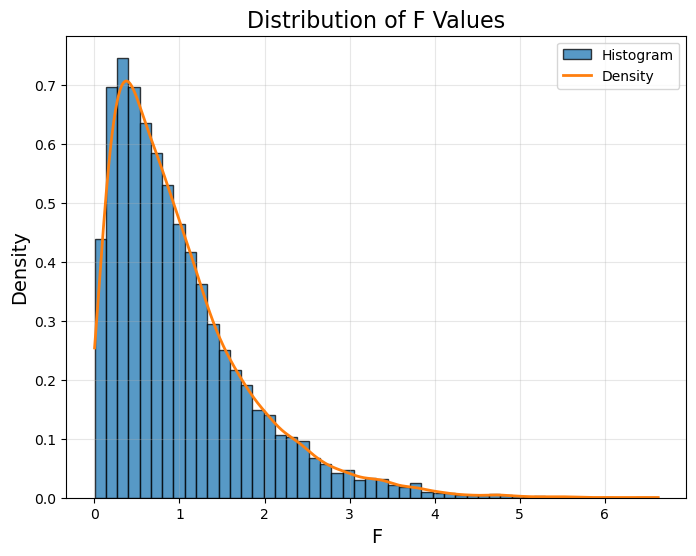

In [420]:
#| code-fold:true

import matplotlib.pyplot as plt

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(f_values, bins=50, density=True, alpha=0.75, edgecolor='black', label='Histogram')

# Optional: Add a density line using a kernel density estimate
from scipy.stats import gaussian_kde
density = gaussian_kde(f_values)
x_vals = np.linspace(min(f_values), max(f_values), 1000)
plt.plot(x_vals, density(x_vals), label='Density', linewidth=2)

# Customize the plot
plt.title('Distribution of F Values', fontsize=16)
plt.xlabel('F', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 不同的 $N$ 与 $K$

设 $N = 3000$，$K = 10$

In [421]:
f_values = []
for _ in range(attempt):
    group_dic = get_group_dic(1, 7, 3000, 10)
    f = calc_f(group_dic)
    f_values.append(f)

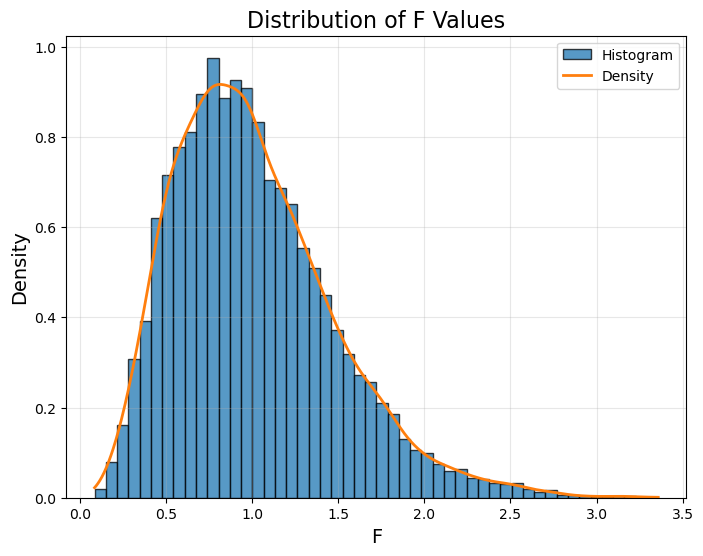

In [422]:
#| code-fold:true

import matplotlib.pyplot as plt

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(f_values, bins=50, density=True, alpha=0.75, edgecolor='black', label='Histogram')

# Optional: Add a density line using a kernel density estimate
from scipy.stats import gaussian_kde
density = gaussian_kde(f_values)
x_vals = np.linspace(min(f_values), max(f_values), 1000)
plt.plot(x_vals, density(x_vals), label='Density', linewidth=2)

# Customize the plot
plt.title('Distribution of F Values', fontsize=16)
plt.xlabel('F', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 结论与未竟事宜

结论就是，如果我们知道 $N$ 与 $K$，那么就可以通过对比上面的图，知道 $H_0: \mu_1 = \mu_2 = ... \mu_K$ 是否成立。

但是有几个点我还没搞清楚：

- 为什么 F 的期望值是 1，因此 F 检验是一个单尾检测？
- 上面的模拟我没有考虑各组样本量不同的情况，如何证明其不影响最后的结果？
- 需要严谨的数学证明来推导出在已知两个既定自由度情况下，F 分布的 PDF 与 CDF 的精确公式。这样就不用每次都模拟，而且更为精确。

这些工作就让我的学生 [Ronald Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher) 来完成吧。 